
<img align="right" src="https://i.imgur.com/cHp1Owf.gif">

# Quantum state learning

This notebook works through the process used to produce the state preparation results presented in [*"Machine learning method for state preparation and gate synthesis on photonic quantum computers"*](https://iopscience.iop.org/article/10.1088/2058-9565/aaf59e/pdf).

We use the continuous-variable (CV) quantum optical circuit package [Strawberry Fields](https://github.com/XanaduAI/strawberryfields), and in particular its TensorFlow backend, to perform quantum circuit optimization. By leveraging Tensorflow, we have access to a number of additional funtionalities, including GPU integration, automatic gradient computation, built-in optimization algorithms, and other machine learning tools.

## Variational quantum circuits

A key element of machine learning is optimization. We can use Tensorflow’s automatic differentiation tools to optimize the parameters of variational quantum circuits constructed using Strawberry Fields. In this approach, we fix a circuit architecture where the states, gates, and/or measurements may have learnable parameters $\vec{\theta}$ associated with them. We then define a loss function based on the output state of this circuit. In this case, we define a loss function such that the fidelity of the output state of the variational circuit is maximized with respect to some target state. For more details on the TensorFlow backend in Strawberry Fields, please see the [Strawberry Fields documentation](http://strawberryfields.readthedocs.io/en/stable/tutorials/tutorial_machine_learning.html).

For arbitrary state preparation using optimization, we need to make use of a quantum circuit with a layer structure that is **universal** - that is, by 'stacking' the layers, we can guarantee that we can produce *any* CV state with at-most polynomial overhead. Therefore, the architecture we choose must consist of layers with each layer containing parameterized Gaussian *and* non-Gaussian gates. **The non-Gaussian gates provide both the nonlinearity and the universality of the model.** To this end, we employ the CV quantum neural network architecture described below:

![layer](https://i.imgur.com/NEsaVIX.png)

Here,


* $\mathcal{U}_i(\theta_i,\phi_i)$ is an N-mode linear optical interferometer composed of two-mode beamsplitters $BS(\theta,\phi)$ and single-mode rotation gates $R(\phi)=e^{i\phi\hat{n}}$,

* $\mathcal{D}(\alpha_i)$ are single mode displacements in the phase space by complex value $\alpha_i$,

* $\mathcal{S}(r_i, \phi_i)$ are single mode squeezing operations of magnitude $r_i$ and phase $\phi_i$, and

* $\Phi(\lambda_i)$ is a single mode non-Gaussian operation, in this case chosen to be the Kerr interaction $\mathcal{K}(\kappa_i)=e^{i\kappa_i\hat{n}^2}$ of strength $\kappa_i$.

<br/>

<div class="alert alert-success" style="border: 0px; border-left: 3px solid #119a68; color: black; background-color: #daf0e9">
<p style="color: #119a68;"><strong>Reference</strong></p>Killoran, N., Bromley, T. R., Arrazola, J. M., Schuld, M., Quesada, N., & Lloyd, S. (2018). "Continuous-variable quantum neural networks." <a href=https://arxiv.org/abs/1806.06871>arXiv:1806.06871</a>.
</div>

## Hyperparameters


First, we must define the **hyperparameters** of our layer structure:

* `cutoff`: the simulation Fock space truncation we will use in the optimization. The TensorFlow backend will perform numerical operations in this truncated Fock space when performing the optimization.


* `depth`: The number of layer ansatz in our variational quantum circuit. As a general rule, increasing the number of layers (and thus, the number of parameters we are optimizing over) increases the optimizers chance of finding a reasonable local minimum in the optimization landscape.


* `reps`: the number of steps in the optimization routine performing gradient descent

Some other optional hyperparameters include:

* The standard deviation of initial parameters. Note that we make a distinction between the standard deviation of *passive* parameters (those that preserve photon number when changed, such as phase parameters), and *active* parameters (those that introduce or remove energy from the system when changed).

In [1]:
# Cutoff dimension
cutoff = 10

# Number of layers
depth = 20

# Number of steps in optimization routine performing gradient descent
reps = 1000

# Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

## The layer parameters $\vec{\theta}$

We use TensorFlow to create the variables corresponding to the gate parameters. Note that each variable has shape `[depth]`, with each individual element representing the gate parameter in layer $i$.

In [2]:
import tensorflow as tf

In [3]:
# squeeze gate
sq_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
sq_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# displacement gate
d_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
d_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# rotation gates
r1 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))
r2 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# kerr gate
kappa = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))

For convenience, we store the TensorFlow variables representing the parameters in a list:

In [4]:
params = [r1, sq_r, sq_phi, r2, d_r, d_phi, kappa]

Now, we can create a function to define the $i$th layer, acting on qumode `q`. This allows us to simply call this function in a loop later on when we build our circuit.

In [5]:
# layer architecture
def layer(i, q):
    Rgate(r1[i]) | q
    Sgate(sq_r[i], sq_phi[i]) | q
    Rgate(r2[i]) | q
    Dgate(d_r[i], d_phi[i]) | q
    Kgate(kappa[i]) | q
    
    return q

## Constructing the circuit

Now that we have defined our gate parameters and our layer structure, we can import Strawberry Fields and construct our variational quantum circuit. Note that, to ensure the TensorFlow backend computes the circuit symbolically, we specify `eval=False`.

In [6]:
import strawberryfields as sf
from strawberryfields.ops import *

In [8]:
# Start SF program
prog = sf.Program(1)

# Apply circuit of layers with corresponding depth
with prog.context as q:
    for k in range(depth):
        layer(k, q[0])

# Run engine
eng = sf.Engine('tf', backend_options={"cutoff_dim": cutoff})
state = eng.run(prog, run_options={"eval": False}).state
ket = state.ket()

Note that the output state vector is an unevaluated tensor:

In [9]:
ket

<tf.Tensor 'ket:0' shape=(10,) dtype=complex64>

## Performing the optimization

$\newcommand{ket}[1]{\left|#1\right\rangle}$ With the Strawberry Fields TensorFlow backend calculating the resulting state of the circuit symbolically, we can use TensorFlow to optimize the gate parameters to minimize the cost function we specify. With state learning, the measure of distance between two quantum states is given by the **fidelity of the output state $\ket{\psi}$ with some target state $\ket{\psi_t}$**. This is defined as the overlap between the two states:

$$ F = \left|\left\langle{\psi}\mid{\psi_t}\right\rangle\right|^2$$

where the output state can be written $\ket{\psi}=U(\vec{\theta})\ket{\psi_0}$, with $U(\vec{\theta})$ the unitary operation applied by the variational quantum circuit, and $\ket{\psi_0}=\ket{0}$ the initial state.

Let's define the target state as the single photon state $\ket{\psi_t}=\ket{1}$:

In [12]:
import numpy as np

In [13]:
target_state = np.zeros([cutoff])
target_state[1] = 1

In [14]:
target_state

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

Using this target state, we calculate the fidelity with the state exiting the variational circuit. We must use TensorFlow functions to manipulate this data, as were are working with symbolic variables!

In [15]:
fidelity = tf.abs(tf.reduce_sum(tf.conj(ket) * target_state)) ** 2

We choose the following cost function:

$$C(\vec{\theta}) = \left| \langle \psi_t \mid U(\vec{\theta})\mid 0\rangle - 1\right|$$

By minimizing this cost function, the variational quantum circuit will prepare a state with high fidelity to the target state.

In [16]:
# Objective function to minimize
cost = tf.abs(tf.reduce_sum(tf.conj(ket) * target_state) - 1)

Now that the cost function is defined, we can define and run the optimization. Below, we choose the Adam optimizer that is built into TensorFlow.

In [17]:
# Using Adam algorithm for optimization
optimiser = tf.train.AdamOptimizer()
min_cost = optimiser.minimize(cost)

# Begin Tensorflow session
session = tf.Session()
session.run(tf.global_variables_initializer())

We then loop over all repetitions, storing the best predicted fidelity value. 

In [18]:
fid_progress = []
best_fid = 0

# Run optimization
for i in range(reps):

    # one repitition of the optimization
    _, cost_val, fid_val, ket_val = session.run([min_cost, cost, fidelity, ket])

    # Stores fidelity at each step
    fid_progress.append(fid_val)
    
    if fid_val > best_fid:
        # store the new best fidelity and best state
        best_fid = fid_val
        learnt_state = ket_val

    # Prints progress at every 10 reps
    if i % 100 == 0:
        print("Rep: {} Cost: {:.4f} Fidelity: {:.4f}".format(i, cost_val, fid_val))

Rep: 0 Cost: 0.9953 Fidelity: 0.0000
Rep: 100 Cost: 0.0404 Fidelity: 0.9209
Rep: 200 Cost: 0.0111 Fidelity: 0.9793
Rep: 300 Cost: 0.0068 Fidelity: 0.9889
Rep: 400 Cost: 0.0051 Fidelity: 0.9932
Rep: 500 Cost: 0.0042 Fidelity: 0.9954
Rep: 600 Cost: 0.0037 Fidelity: 0.9967
Rep: 700 Cost: 0.0033 Fidelity: 0.9975
Rep: 800 Cost: 0.0031 Fidelity: 0.9980
Rep: 900 Cost: 0.0029 Fidelity: 0.9984


## Results and visualisation

Plotting the fidelity vs. optimization step:

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Computer Modern Roman']
plt.style.use('default')

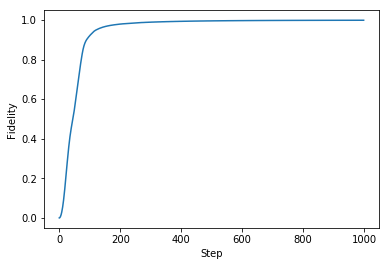

In [20]:
plt.plot(fid_progress)
plt.ylabel('Fidelity')
plt.xlabel('Step');

We can use the following function to plot the Wigner function of our target and learnt state:

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def wigner(rho):
    """This code is a modified version of the ‘iterative’ method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.
    
    All rights reserved."""
    import copy
    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m)
                    * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

Computing the density matrices $\rho = \left|\psi\right\rangle \left\langle\psi\right|$ of the target and learnt state,

In [22]:
rho_target = np.outer(target_state, target_state.conj())
rho_learnt = np.outer(learnt_state, learnt_state.conj())

Plotting the Wigner function of the target state:

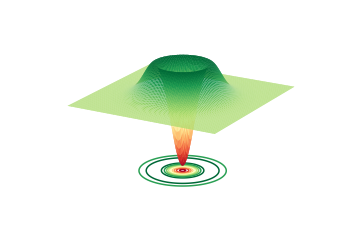

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax.set_axis_off()

Plotting the Wigner function of the learnt state:

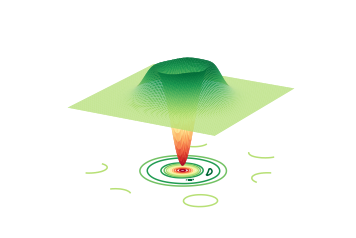

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax.set_axis_off()

## References

[1] Juan Miguel Arrazola, Thomas R. Bromley, Josh Izaac, Casey R. Myers, Kamil Brádler, and Nathan Killoran. *Machine learning method for state preparation and gate synthesis on photonic quantum computers.* [Quantum Science and Technology. 4 024004](https://iopscience.iop.org/article/10.1088/2058-9565/aaf59e/pdf), 2019.

[2] Killoran, N., Bromley, T. R., Arrazola, J. M., Schuld, M., Quesada, N., & Lloyd, S. *Continuous-variable quantum neural networks.* <a href=https://arxiv.org/abs/1806.06871>arXiv:1806.06871</a>, 2018.